In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo

In [2]:
# Example graph
n = 5  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 3, 1.0), (0, 4, 1.0), (1, 2, 1.0), (1, 3, 1.0), (1, 4, 1.0), (2, 3, 1.0), (2, 4, 1.0), (3, 4, 1.0)]

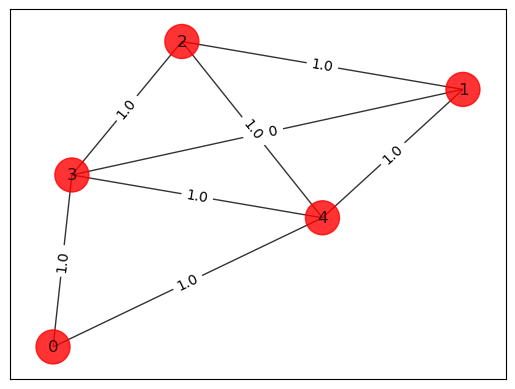

In [3]:
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [4]:
from qiskit_optimization.applications.clique import Clique

clique_problem = Clique(graph=G, size=None)


In [5]:
qp = clique_problem.to_quadratic_program()
# Convert the quadratic program to a QUBO
qubo_converter = QuadraticProgramToQubo()
qubo_problem = qubo_converter.convert(qp)
qubitOp, offset = qubo_problem .to_ising()


In [6]:
algorithm_globals.random_seed = 123
seed = 10598

energy: -4.217745047986576
time: 4.968964576721191
clique_problem  objective: -3.7177450479865763
solution: [0 1 1 1 1]
solution objective: 4.0


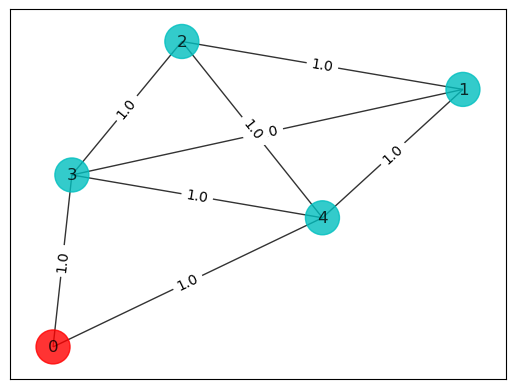

In [7]:
# construct SamplingVQE
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

# run SamplingVQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = clique_problem .sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("clique_problem  objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)